In [1]:
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torchsampler import ImbalancedDatasetSampler
import matplotlib.pyplot as plt
import os
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from functools import reduce
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
import pandas as pd
import sklearn 

In [2]:
import loaders as l
import models as m

In [6]:
def calc_metrics_v1(net,loader,all_labels,all_predicted,show=True) : 

    for i, data in enumerate(loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            outputs = net(inputs)
            y_pred_softmax = torch.log_softmax(outputs, dim = 1)
            _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)
            all_predicted.extend(np.array(y_pred_tags))
            all_labels.extend(np.array(labels))
    
    f1s=f1_score(all_labels,all_predicted,average='weighted')
    prec=precision_score(all_labels,all_predicted,average='weighted')
    rec=recall_score(all_labels,all_predicted,average='weighted')
    cf_m=pd.DataFrame(sklearn.metrics.confusion_matrix(all_labels, all_predicted,normalize='true'))
    
    if show ==True : 
        print("f1_score ",f1s)
        print("precision ",prec)
        print("recall ",rec)
        print("confusion matrix\n", cf_m)
        
    return f1s,prec,rec,cf_m

In [9]:
def train_v1(net,criterion,optimizer,epochs,train_loader,valid_loader):
    
    all_labels=[]
    all_predicted=[]
    all_losses=[]
    all_accuracies=[]
    all_f1scores=[]
    
    for epoch in range(epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        for n_batch,batch in enumerate(train_loader) : 
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = batch

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            all_labels.extend(np.array(labels))

            _, predicted = torch.max(outputs.data, 1)
            all_predicted.extend(np.array(predicted))

            running_loss += loss.item()
            if n_batch % 2000 == 1999:    # print every 10 mini-batches

                #peut-être ça ne sert plus---------
                y_pred_softmax = torch.log_softmax(outputs, dim = 1)
                _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)
                outputs=np.array(y_pred_tags)
                labels=np.array(labels)
                #---------------------------------
                all_losses.append(running_loss / n_batch)
                f1 = calc_metrics_v1(net,valid_loader,all_labels,all_predicted,False)[0]
                all_f1scores.append(f1)
                print('[%2d, %2d] loss: %.3f f1_score on validation set : %.3f' %
                      (epoch + 1, n_batch + 1, running_loss / n_batch,f1))

                running_loss = 0.0
            
    
    return all_labels,all_predicted,all_losses,all_accuracies,all_f1scores

BaseNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
[ 1, 2000] loss: 0.529 f1_score on validation set : 0.788
[ 2, 2000] loss: 0.151 f1_score on validation set : 0.870


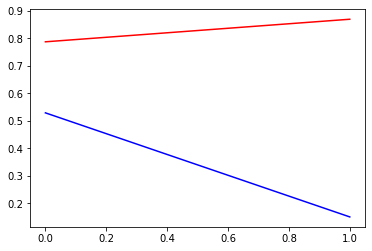

In [8]:

'''
train_dir = 'C:/Users/33783/Desktop/start_deep/start_deep/train_images'
test_dir = 'C:/Users/33783/Desktop/start_deep/start_deep/test_images'

transform = transforms.Compose(
    [transforms.Grayscale(), 
     transforms.ToTensor(), 
     transforms.Normalize(mean=(0,),std=(1,))])

valid_size = 0.2
batch_size = 32

train_loader,valid_loader,test_loader=l.make_all_loaders(train_dir,test_dir,transform,valid_size,batch_size)
classes = ('noface','face')

net = m.BaseNet()
print(net)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

epochs=2
#Training

all_labels,all_predicted,all_losses,all_accuracies,all_f1scores= train_v1(net,criterion,optimizer,epochs,train_loader,valid_loader)
            
plt.plot(all_losses, color='blue')
plt.plot(all_f1scores, color='red')
'''